3 Way classifier for Spectral Data that was recorded of 3 different colored pieces of paper. Some help from https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab and course notes/ lectures from BME 548: Machine Learning in Imaging at Duke University

In [ ]:
from zipfile import ZipFile
file_name = '/content/Data_NNlearn.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns


import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
class NNlib():

    def __init__(self):

        
        self.c1 = "Data_NNlearn/class_1/"
        self.c2 = "Data_NNlearn/class_2/"
        self.c3 = "Data_NNlearn/class_3/"

        

    def data_read(self):

        folder1 = self.c1
        folderinfor1 = glob(self.c1 + "*.csv")
        # print("folderinfor = ", folderinfor1)
  

        folder2 = self.c2
        folderinfor2 = glob(self.c2 + "*.csv")
        # print("folderinfor = ", folderinfor2)
 
        folder3 = self.c3
        folderinfor3 = glob(self.c3 + "*.csv")
        # print("folderinfor = ", folderinfor3)


        ## Make list of folders, then loop through each folder and read csv and concatenate with previously read csv's
        ## Take out leading column used to start array and transpose result to get (70, 3648) ndarray
        ## Concatenate a vector of the class types for each data file (0, 1, 2) for ease of computation
        all_data = [folderinfor1, folderinfor2, folderinfor3]
        output_array = np.zeros((3648, 1))  
        for class_type in all_data:
            for file in class_type:
              data = np.genfromtxt(str(file), delimiter=',', usecols=1)
              data = np.reshape(data, (3648, 1))
              output_array = np.concatenate((output_array, data), axis=1) 
        output_array = np.transpose(output_array[:, 1:])

        class_vector = np.concatenate((np.zeros((len(folderinfor1), 1)), np.ones((len(folderinfor2), 1)), 2*np.ones((len(folderinfor3), 1))), axis=0)
        output_array = np.concatenate((output_array, class_vector), axis=1)
        # print(output_array.shape)
        return output_array


        # for i in folderinfor2:
        #     idx_data = i
        #     #print(idx_data)
        #     data = np.genfromtxt(str(idx_data), delimiter=',', usecols=1)
        #     print(type(data))
        #     print("mean intensity = ", np.mean(data))
        #     plt.plot(data)
        #     plt.show()
        #     break

In [ ]:
files= NNlib()
data_frame = files.data_read()
x = data_frame[:, :-1]; y = data_frame[:, -1]  # may need to change y_data shape from (70, ) to (70, 1)
print(y.shape)

(70,)


In [ ]:
# Split into train+val and test, stratify ensures classes have equal representation in train, val, test, since they are disproportionate
X_trainval, X_test, y_trainval, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [ ]:
# Normalize output by (x-min)/(max-min). Fit to train data, and transform val and test using train metrics to prevent leakage
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

Visualize data distribution in train val and test sets

In [ ]:
def get_class_distribution(obj):
    count_dict = {
        "class_1": 0,
        "class_2": 0,
        "class_3": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['class_1'] += 1
        elif i == 1: 
            count_dict['class_2'] += 1
        elif i == 2: 
            count_dict['class_3'] += 1              
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

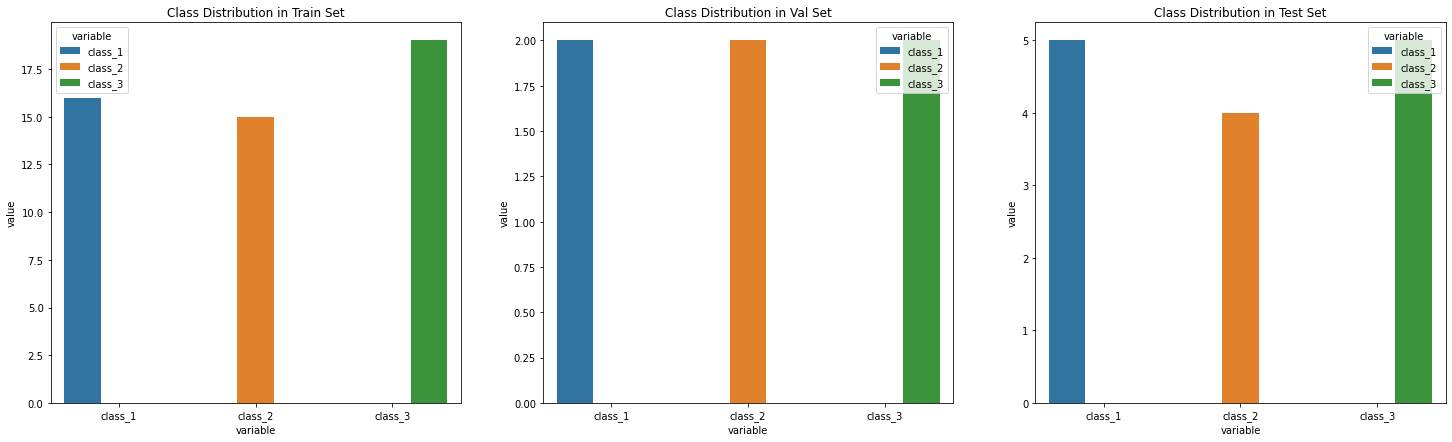

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

Now to create iterable from dataset, create model, send to GPU for training

In [ ]:
#  inherits from Dataset superclass, but adds functionality of receiving X, Y data and finding couple extra things

class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [ ]:
# classes are not identical in distribution, so use weighted rndom sampler, first get labels from train iterable
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

# get counts of each class and divide to get weights of each class
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

# create list with weights in for target list vals now
class_weights_all = class_weights[target_list]


tensor([0.0625, 0.0667, 0.0526])


In [ ]:
# instantiate Weighted random sampler to deal with disproportionate dist of classes (not that disproportionate), use weights list, number data points (70)
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

Set up model and parameters

In [ ]:
EPOCHS = 5
BATCH_SIZE = 8
LEARNING_RATE = 0.0001
NUM_FEATURES = x.shape[1]
NUM_CLASSES = 3

In [ ]:
# remember, we do not use shuffle=TRUE in this case since we use a sampler, the two cannot be used at the same time
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [ ]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [ ]:
# Pytorch is more low level than tensorflow in that you must explicitly create an object of GPU, check activity, and send relevant things to it for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=3648, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


Now Train, but for this case, dont use huge batch sizes since data is small, don't use huge epochs since this should be pretty simple and overfitting could happen. Potentially leave out a few Batch Normas, since we have small data, but if using, you can increase LR.

In [ ]:
# compute accuracy, send y_pred from model into a log_softmax, which floors or celings to nearest prediction, chooses one with best prob
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [ ]:
print("Begin training.")
for e in range(1, EPOCHS+1):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.
Epoch 001: | Train Loss: 0.85368 | Val Loss: 1.02643 | Train Acc: 66.143| Val Acc: 83.333
Epoch 002: | Train Loss: 0.56924 | Val Loss: 0.89117 | Train Acc: 94.714| Val Acc: 100.000
Epoch 003: | Train Loss: 0.53014 | Val Loss: 0.73065 | Train Acc: 96.571| Val Acc: 100.000
Epoch 004: | Train Loss: 0.49819 | Val Loss: 0.54025 | Train Acc: 91.143| Val Acc: 100.000
Epoch 005: | Train Loss: 0.42641 | Val Loss: 0.48049 | Train Acc: 98.286| Val Acc: 100.000


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

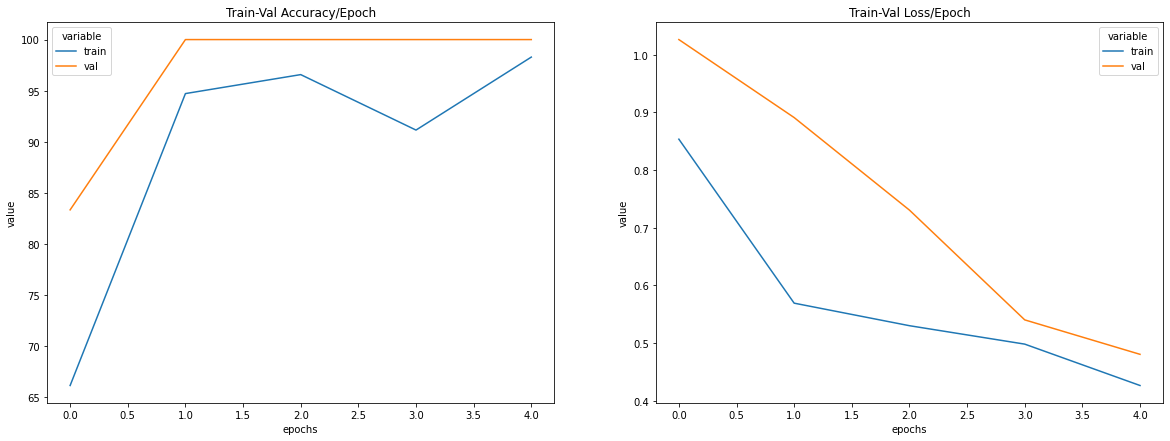

In [ ]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')


Test the model

In [ ]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         5
         1.0       1.00      1.00      1.00         4
         2.0       1.00      1.00      1.00         5

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



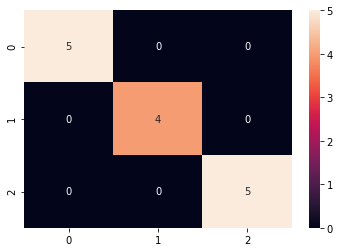

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list))

sns.heatmap(confusion_matrix_df, annot=True)

print(classification_report(y_test, y_pred_list))